In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("sephora_noisy_data.csv")
data.head()


,order_id,order_date,brand,category,product_name,units_sold,unit_price,gross_revenue,discount_pct,net_revenue,client_id,client_segment,channel
0,1,2023-04-13,Dior,Makeup,Cream Blush,4.0,38.08,152.32,30.0,106.62,C2771,High Value,In-Store
1,2,NaN,Rare Beauty,Skincare,SPF 50 Sunscreen,3.0,48.47,145.41,5.0,138.14,C4488,Medium Value,NaN
2,3,2023-09-28,Dior,Haircare,Repair Shampoo,3.0,37.67,113.01,0.0,113.01,C2972,Medium Value,In-Store
3,4,2023-04-17,Glow Recipe,Skincare,Overnight Face Mask,4.0,65.40,261.60,20.0,209.28,C1902,NaN,NaN
4,5,2023-03-13,Fenty Beauty,Makeup,NaN,5.0,17.68,88.40,0.0,88.40,C4920,New,Online


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        3500 non-null   int64  
 1   order_date      3403 non-null   object 
 2   brand           3048 non-null   object 
 3   category        3342 non-null   object 
 4   product_name    2855 non-null   object 
 5   units_sold      3301 non-null   float64
 6   unit_price      3170 non-null   float64
 7   gross_revenue   2995 non-null   float64
 8   discount_pct    3080 non-null   float64
 9   net_revenue     2640 non-null   float64
 10  client_id       3369 non-null   object 
 11  client_segment  2833 non-null   object 
 12  channel         2310 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 355.6+ KB


In [5]:
data.isnull().sum()

,0
order_id,0
order_date,97
brand,452
category,158
product_name,645
units_sold,199
unit_price,330
gross_revenue,505
discount_pct,420
net_revenue,860


In [6]:
data.describe()

,order_id,units_sold,unit_price,gross_revenue,discount_pct,net_revenue
count,3500.000000,3301.000000,3170.000000,2995.000000,3080.000000,2640.000000
mean,1750.500000,3.526810,48.802662,170.458952,14.662338,145.815739
std,1010.507298,1.712952,26.429055,131.221426,9.991858,114.721923
min,1.000000,1.000000,14.000000,14.400000,0.000000,10.890000
25%,875.750000,2.000000,30.562500,77.630000,5.000000,65.197500
50%,1750.500000,4.000000,43.775000,136.480000,15.000000,115.795000
75%,2625.250000,5.000000,58.025000,228.625000,25.000000,191.510000
max,3500.000000,6.000000,149.470000,888.780000,30.000000,832.560000


## **Step 1 : Clean NULL values & inconsistent formatting**

#### **A. Fix order_date**

The `order_date` column contained missing values and improperly formatted date strings.  I used `pd.to_datetime()` with `errors='coerce'` to transform invalid dates into `NaT`

In [7]:
data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')

#### **B. Clean client_id**

The dataset included malformed client IDs such as `ID-57`, as well as missing values. So, I filtered out invalid client IDs by keeping only those that start with the expected prefix `C`.   All other values were converted to `NaN` for further cleaning.

In [8]:
data['client_id'] = data['client_id'].apply(
    lambda x: x if isinstance(x, str) and x.startswith("C") else np.nan)

#### **C. Drop rows where category is missing**

Category is a critical field for any merchandising analysis.  Transactions missing a category cannot be mapped to brand/category performance, seasonality, or product contribution.  To preserve analytical integrity, rows where `category` was missing were removed.

In [9]:
data = data.dropna(subset=['category'])

#### **D. Fix product_name**
Some entries were missing product names, likely due to upstream data-entry or system errors.  Instead of discarding these transactions, I replaced missing product names with `"Unknown Product"`.  
This allows the data to remain usable while still signalling the missingness during SKU-level analysis.


In [10]:
data['product_name'] = data['product_name'].fillna("Unknown Product")

#### **E. Handle unit_price and units_sold**
These missing fields break all revenue calculations.

1.   Unit price can be imputed using median or category-level median.

2.   Units sold can be imputed as zero if truly missing (representing a corrupted log entry).

In [11]:
data['units_sold'] = data['units_sold'].fillna(0)
data['unit_price'] = data['unit_price'].fillna(data['unit_price'].median())

#### **F. Recompute missing revenues**

Some rows had missing or inconsistent revenue fields.  
To restore consistency across the dataset:


1.   `gross_revenue` was recomputed as `unit_price * units_sold`  
2.   `net_revenue` was recalculated using the discount percentage



In [12]:
mask = data['gross_revenue'].isna()
data.loc[mask, 'gross_revenue'] = data.loc[mask, 'units_sold'] * data.loc[mask, 'unit_price']

mask2 = data['net_revenue'].isna()
data.loc[mask2, 'net_revenue'] = data.loc[mask2, 'gross_revenue']

## **Step 2: Feature Engineering**

#### **A. Extract date parts**

To support seasonality, trend, and cohort analysis, I extracted several time-based features:
- `month` for seasonality and month-over-month trends  
- `weekday` to study weekend vs weekday shopping behavior  
- `quarter` for quarterly category and brand reporting

These features help build dashboards and trend analyses consistent with real merchandising workflows.

In [13]:
data['month'] = data['order_date'].dt.to_period('M')
data['weekday'] = data['order_date'].dt.day_name()
data['quarter'] = data['order_date'].dt.quarter

#### **B. Add “price tier” bucket**
I created a `price_tier` feature with four buckets: Budget, Mid, Premium, and Luxury.  This segmentation helps analyze brand strategy, customer spend behavior, and SKU performance across different value tiers.

In [14]:
data['price_tier'] = pd.cut(
    data['unit_price'],
    bins=[0, 25, 50, 100, 200],
    labels=['Budget', 'Mid', 'Premium', 'Luxury']
)


#### **C. Add "holiday season"**
Beauty retail sees a significant revenue spike during November and December.   To capture this effect, I added a `holiday_season` flag that marks transactions occurring in these months.  

In [15]:
data['holiday_season'] = data['order_date'].dt.month.isin([11,12]).astype(int)

## **Step 3: Brand Performance Analysis**

- Understanding brand contribution is central to merchandising.  
- This analysis identifies which brands drive the most revenue, which rely on discounting, and which show strong unit volume.  
- These insights are used to make partnership decisions, plan inventories, and negotiate promotions.


#### **A. Revenue by brand**

Highlights:

- **Rare Beauty** leads all brands with the **highest revenue (~$63.7K)**.

- Glow Recipe and Fenty Beauty follow closely behind, showing strong overall performance.

- Dior, Charlotte Tilbury, and Laneige still perform well but sit slightly lower compared to the top three.

The spread between the highest and lowest brand isn’t huge, which means revenue is fairly balanced across the assortment.

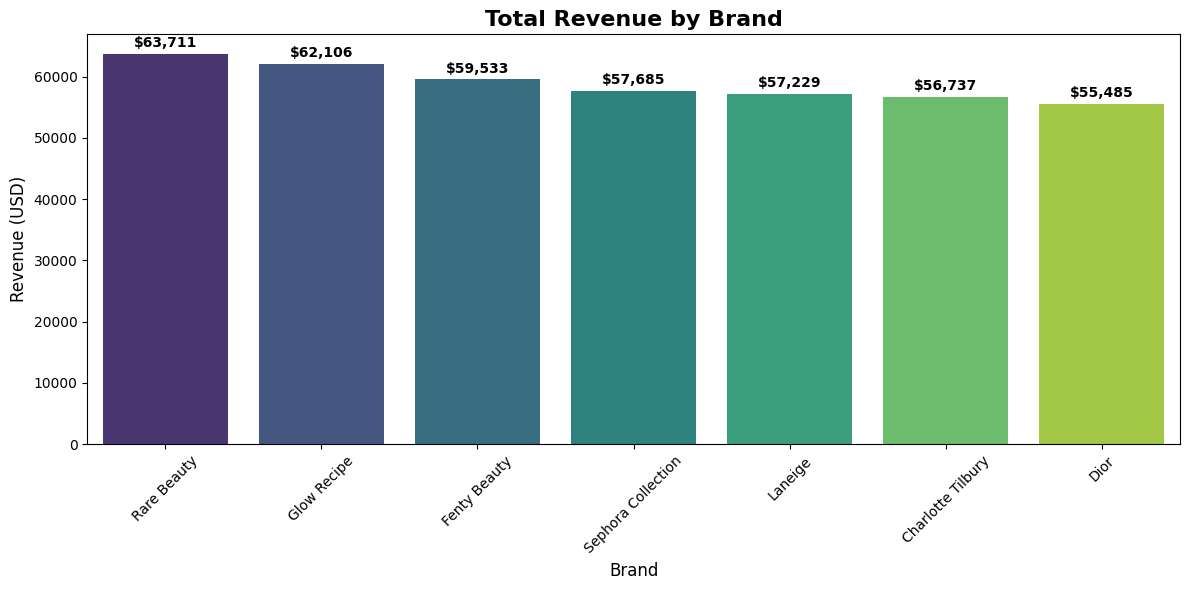

In [16]:
brand_rev = data.groupby("brand")["net_revenue"].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))

ax = sns.barplot(
    x=brand_rev.index,
    y=brand_rev.values,
    hue=brand_rev.index,
    palette="viridis",
    dodge=False,
    legend=False
)

# Add value labels on top of each bar
for i, value in enumerate(brand_rev.values):
    ax.text(
        i,
        value + (0.01 * brand_rev.max()),
        f"${value:,.0f}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Total Revenue by Brand", fontsize=16, fontweight='bold')
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Revenue (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **B. Units sold by brand**

- **Rare Beauty** sold the most units overall **(~1,521)**, which suggests strong demand and high product velocity.

- Fenty Beauty, Glow Recipe, Laneige, and Sephora Collection all sit in a tight cluster, meaning these brands drive consistent, steady volume.

- Dior and Charlotte Tilbury have lower unit sales, which aligns with their higher price points and more premium positioning.

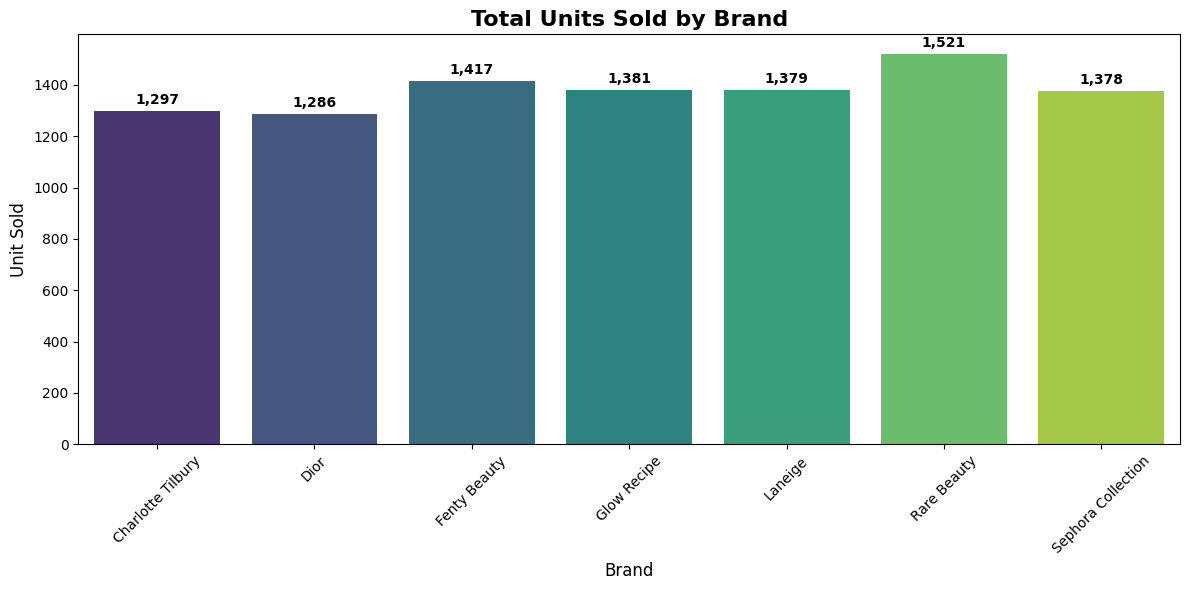

In [17]:
units_brand = data.groupby("brand")["units_sold"].sum()
plt.figure(figsize=(12,6))

ax = sns.barplot(
    x=units_brand.index,
    y=units_brand.values,
    hue=units_brand.index,
    palette="viridis",
    dodge=False,
    legend=False
)

# Add value labels on top of each bar
for i, value in enumerate(units_brand.values):
    ax.text(
        i,
        value + (0.01 * units_brand.max()),
        f"{value:,.0f}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Total Units Sold by Brand", fontsize=16, fontweight='bold')
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Unit Sold", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **C. Discount usage by brand**

- **Rare Beauty** has the **highest average discount (16%)**, which suggests stronger reliance on promotions to drive volume.

- Most brands cluster tightly around **14–15%,** showing similar discount behavior across the assortment.

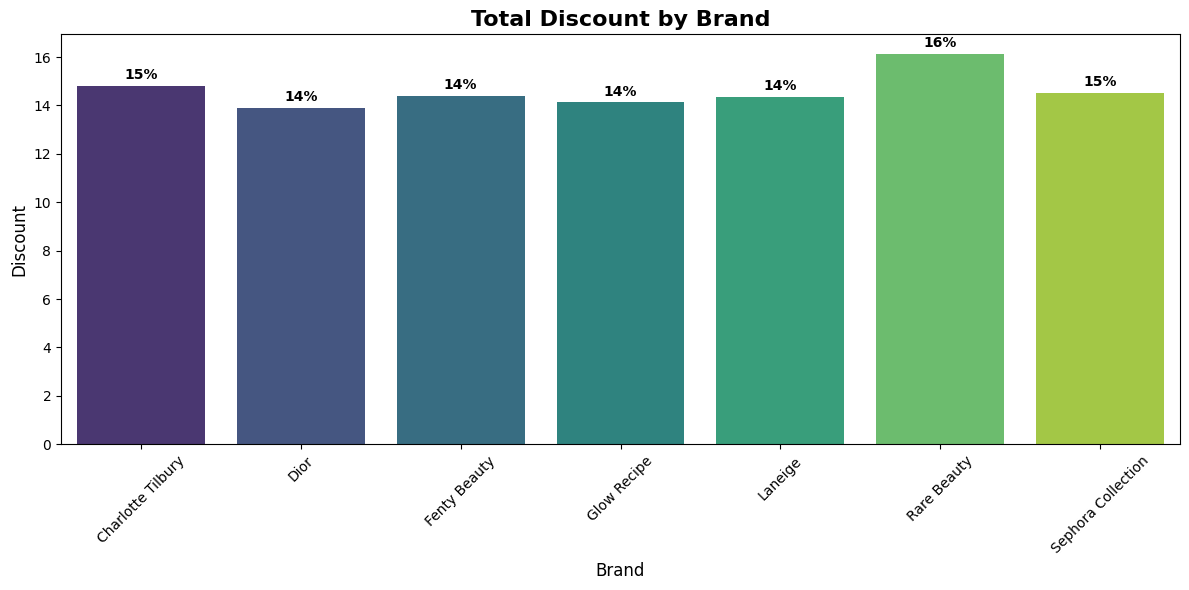

In [18]:
disc_brand = data.groupby("brand")["discount_pct"].mean()
plt.figure(figsize=(12,6))

ax = sns.barplot(
    x=disc_brand.index,
    y=disc_brand.values,
    hue=disc_brand.index,
    palette="viridis",
    dodge=False,
    legend=False
)

# Add value labels on top of each bar
for i, value in enumerate(disc_brand.values):
    ax.text(
        i,
        value + (0.01 * disc_brand.max()),
        f"{value:,.0f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Total Discount by Brand", fontsize=16, fontweight='bold')
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Discount", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **D. Combine all brand KPIs into a single table**

In [19]:
brand_summary = data.groupby("brand").agg(
    total_revenue=("net_revenue","sum"),
    total_units=("units_sold","sum"),
    avg_discount=("discount_pct","mean")
).sort_values("total_revenue", ascending=False)
brand_summary

,total_revenue,total_units,avg_discount
brand,,,
Rare Beauty,63711.100,1521.0,16.131841
Glow Recipe,62106.145,1381.0,14.122340
Fenty Beauty,59532.590,1417.0,14.375000
Sephora Collection,57685.120,1378.0,14.527778
Laneige,57228.770,1379.0,14.356164
Charlotte Tilbury,56736.730,1297.0,14.814815
Dior,55485.165,1286.0,13.890490


## **Step 5: Category Trend & Seasonality Analysis**

Different categories exhibit unique seasonal patterns.
By analyzing monthly revenue across categories, we can highlight seasonality, identify emerging needs, and support stocking and promotional strategies.



Highlights:

- **Fragrance** clearly spikes in **September–October**, which lines up with holiday and gifting season.

- **Makeup** peaks around **May–June**, suggesting stronger performance during early summer.

- **Skincare** stays fairly steady but dips in midsummer, then picks up again toward **year-end**.

- **Haircare** remains the **lowest and most stable category**, with smaller ups and downs throughout the year.

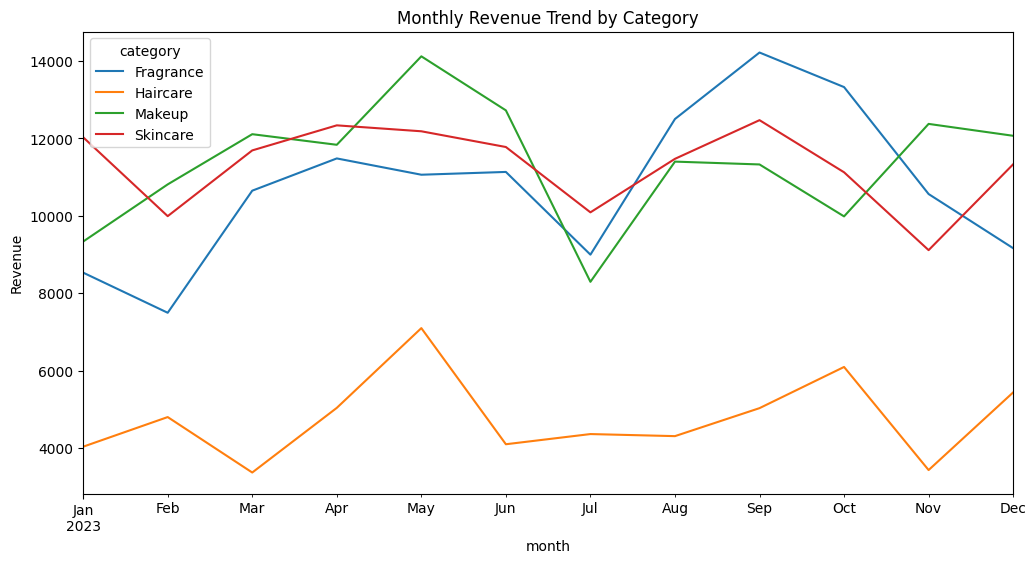

In [20]:
cat_trend = data.groupby(["month", "category"])["net_revenue"].sum().unstack()

cat_trend.plot(figsize=(12,6), title="Monthly Revenue Trend by Category")
plt.ylabel("Revenue")
plt.show()


## **Step 6: SKU-Level Product Analysis**

Merchandising teams track individual product performance to optimize assortment.  By analyzing SKU-level units and revenue, we can identify hero products, niche performers, and underperforming items.


#### **A. Top 15 SKUs**

- **Fragrance** products take most of the top spots, meaning they bring in the **highest SKU-level revenue**.

- Skincare items like cleansers, moisturizers, masks, and SPF also perform well.

- Makeup SKUs appear lower on the list, so their revenue is more spread out across many products.


In [21]:
# Filter out Unknown Product
df_known = data[data["product_name"] != "Unknown Product"]

# Recompute top 15 SKUs without Unknown Product
top_skus = (
    df_known.groupby("product_name")["net_revenue"]
            .sum()
            .sort_values(ascending=False)
            .head(15)
)

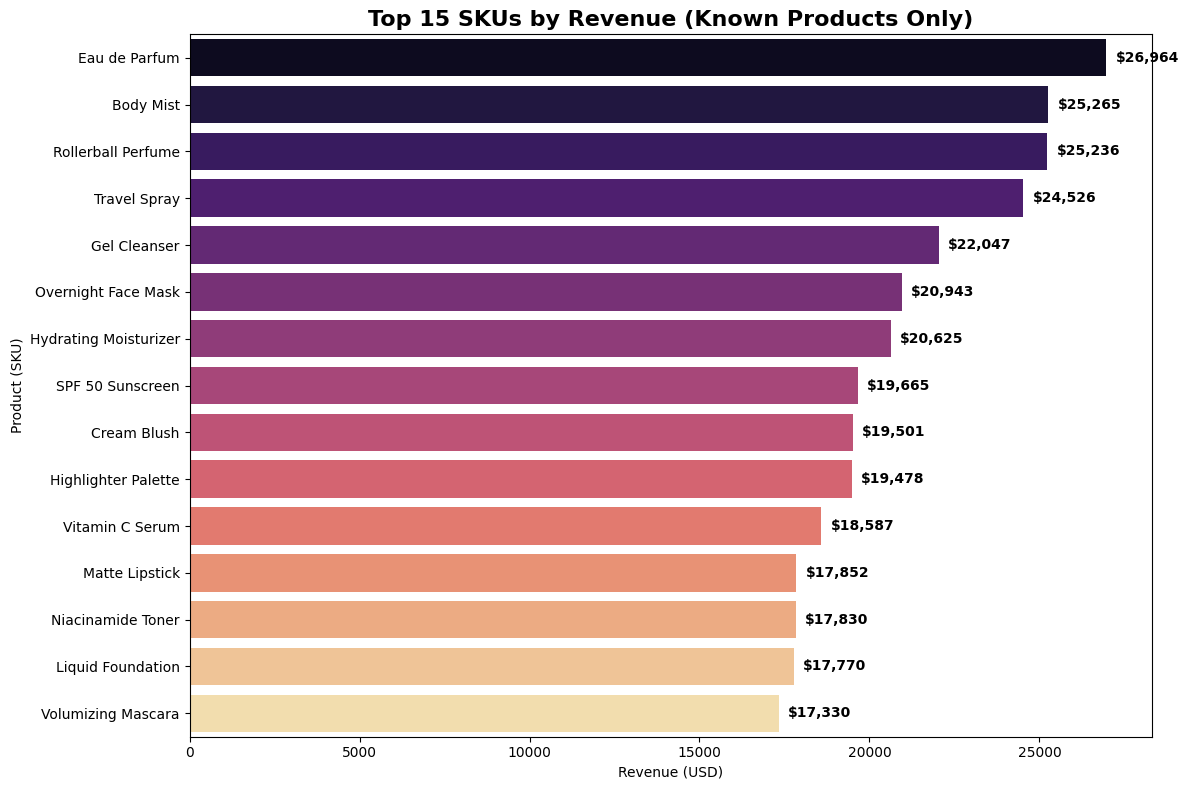

In [22]:
# Filter out Unknown Product
df_known = data[data["product_name"] != "Unknown Product"]

# Recompute top 15 SKUs without Unknown Product
top_skus = (
    df_known.groupby("product_name")["net_revenue"]
            .sum()
            .sort_values(ascending=False)
            .head(15)
)

# Prepare for plotting
sku_df = top_skus.reset_index()
sku_df.columns = ["product_name", "net_revenue"]

plt.figure(figsize=(12,8))

ax = sns.barplot(
    data=sku_df,
    y="product_name",
    x="net_revenue",
    hue="product_name",
    palette="magma",
    dodge=False,
    legend=False
)

# Add labels
for i, (name, value) in enumerate(zip(sku_df["product_name"], sku_df["net_revenue"])):
    ax.text(
        value + (0.01 * sku_df["net_revenue"].max()),
        i,
        f"${value:,.0f}",
        va='center',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Top 15 SKUs by Revenue (Known Products Only)", fontsize=16, fontweight='bold')
plt.xlabel("Revenue (USD)")
plt.ylabel("Product (SKU)")
plt.tight_layout()
plt.show()


## **Step 7: Client Behavior Analytics**

Client segments such as New, Low Value, Medium Value, and High Value provide a lens into purchase behavior.  
Analyzing segment-level spend helps identify retention opportunities, promotional sensitivity, and loyalty patterns.

#### **A. Revenue by segment**

In [23]:
data.groupby("client_segment")["net_revenue"].sum().sort_values(ascending=False)


,net_revenue
client_segment,
High Value,103942.335
Low Value,97117.900
Medium Value,89788.910
New,88136.835


#### **B.Repeat purchase frequency**

- Most customers buy only once, which means the majority are one-time shoppers.

- A smaller group makes two purchases, and very few go beyond that.

- This shows low repeat behavior overall, suggesting there’s room to improve customer retention and encourage follow-up purchases.

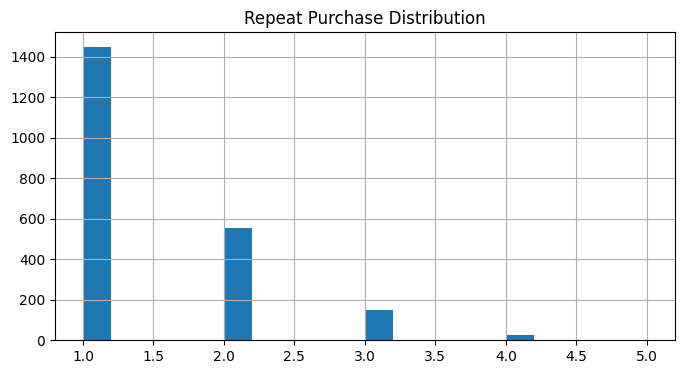

In [24]:
order_freq = data.groupby("client_id")["order_id"].count()
order_freq.hist(bins=20, figsize=(8,4))
plt.title("Repeat Purchase Distribution")
plt.show()

## **Step 8: Discount Impact Analysis**

Understanding how discounts affect units sold and revenue is crucial for pricing and promotion strategy.  This analysis reveals whether deeper discounts drive meaningful volume uplift or unnecessarily reduce net revenue.


#### **A. Discount vs units sold**

- Units sold stay almost the same across all discount levels.

- Even higher discounts (20–30%) don’t lead to a meaningful lift in quantity sold.

- This suggests that discounts are not a major driver of volume in this dataset.

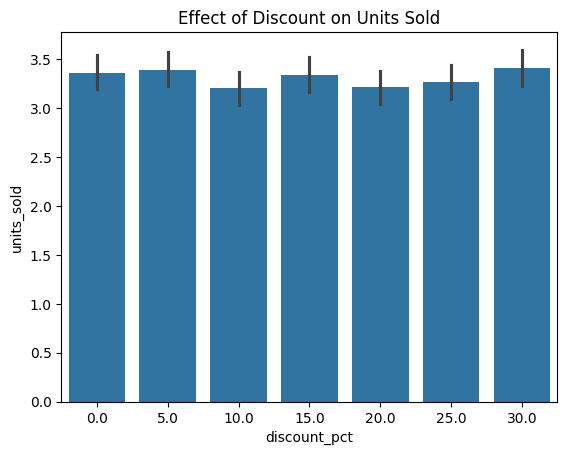

In [25]:
sns.barplot(x="discount_pct", y="units_sold", data=data)
plt.title("Effect of Discount on Units Sold")
plt.show()


#### **B. Discount vs revenue**
- As the discount increases, average revenue per order drops steadily.

- The biggest difference is between no discount and any discount, showing an immediate hit to revenue.

- Since units sold didn’t increase much with discounts (previous chart), these discounts mostly reduce revenue without boosting volume.

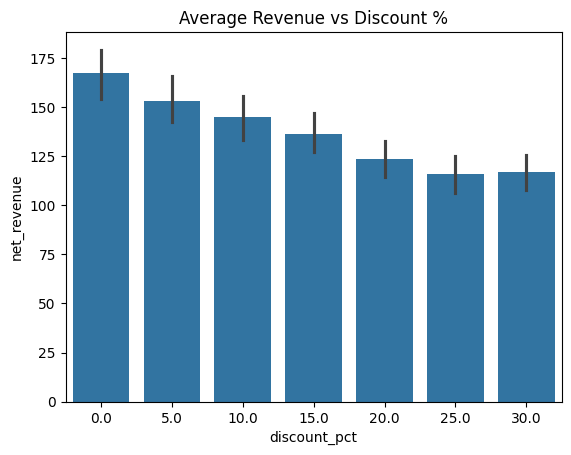

In [26]:
sns.barplot(x="discount_pct", y="net_revenue", data=data)
plt.title("Average Revenue vs Discount %")
plt.show()

## **Step 9: Channel Analysis**
Customers behave differently depending on the shopping channel.  Comparing online and in-store performance helps identify omni-channel strengths, conversion patterns, and opportunities to shift assortment.

Highlights:

- Online revenue is slightly higher than in-store revenue.

- The gap isn’t huge, which means both channels are performing at similar levels.

- Overall, sales are well balanced across channels, not overly dependent on one.

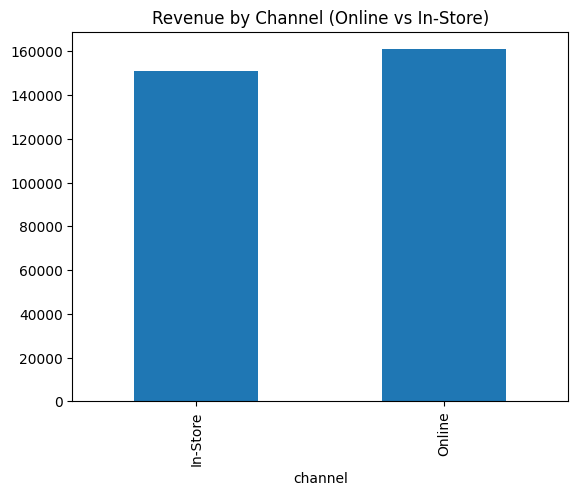

In [27]:
data.groupby("channel")["net_revenue"].sum().plot(kind='bar')
plt.title("Revenue by Channel (Online vs In-Store)")
plt.show()